In [1]:
import sqlite3
import pandas as pd
import matplotlib as plt
%matplotlib inline

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)    

In [3]:
def run_command(q):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(q)

In [4]:
def show_tables():
    q = "SELECT name, type FROM sqlite_master WHERE type IN ('table','view');"
    df = run_query(q)
    print(df)

In [5]:
show_tables()

              name   type
0            album  table
1           artist  table
2         customer  table
3         employee  table
4            genre  table
5          invoice  table
6     invoice_line  table
7       media_type  table
8         playlist  table
9   playlist_track  table
10           track  table


In [6]:

q = '''
    WITH genretypes AS
    (
        SELECT track.genre_id, genre.name
        FROM track
        
        INNER JOIN genre
        ON track.genre_id = genre.genre_id
    )
    SELECT DISTINCT genretypes.genre_id, genretypes.name
    FROM genretypes
'''

q = '''
    WITH 
    genretypes AS
    (
        SELECT track.track_id, track.genre_id, genre.name
        FROM track
        
        INNER JOIN genre
        ON track.genre_id = genre.genre_id
    ),
    sellinfo AS
    (
        SELECT invoice_line.track_id, invoice.total
        FROM invoice_line
        
        INNER JOIN invoice
        ON invoice.invoice_id = invoice_line.invoice_id
    )
    SELECT genretypes.name as name, SUM(sellinfo.total) AS total
    FROM sellinfo
    
    INNER JOIN genretypes
    ON genretypes.track_id = sellinfo.track_id
    GROUP BY genretypes.genre_id
    HAVING (name = "Hip Hop/Rap" or name = "Alternative & Punk" or name = "Pop" or name = "Blues")
    ORDER BY total DESC
'''

run_query(q)

,name,total
0,Alternative & Punk,4841.10
1,Blues,1379.07
2,Pop,568.26
3,Hip Hop/Rap,463.32


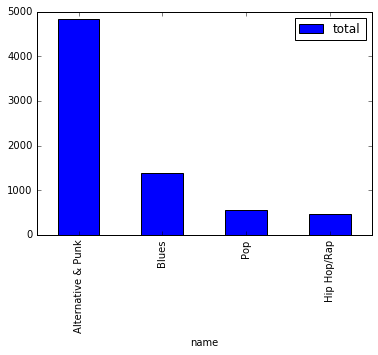

In [7]:
df = run_query(q)
df = df.set_index('name')
df.plot.bar()


In [12]:
q = '''
    WITH supportstaff AS
    (
        SELECT
        DISTINCT employee_id,
        first_name || " " || last_name AS name
        FROM employee
    )
    SELECT
    customer.support_rep_id,
    supportstaff.name,
    SUM(invoice.total) AS total
    
    FROM customer
    
    INNER JOIN invoice
    ON invoice.customer_id = customer.customer_id
    
    INNER JOIN supportstaff
    ON supportstaff.employee_id = customer.support_rep_id
    
    GROUP BY customer.support_rep_id
    ORDER BY customer.support_rep_id
    
'''
run_query(q)

,support_rep_id,name,total
0,3,Jane Peacock,1731.51
1,4,Margaret Park,1584.00
2,5,Steve Johnson,1393.92


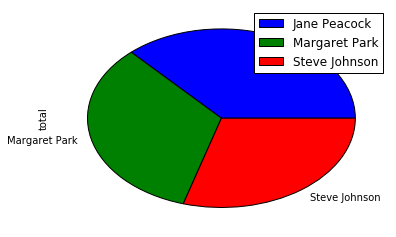

In [17]:
df = run_query(q)
df = df.set_index("name")
df.plot.pie("total")

In [21]:
q = "DROP VIEW countrydata"
run_command(q)
q = '''
    CREATE VIEW countrydata AS
    SELECT 
    customer.customer_id,
    customer.country,
    invoice.total
    FROM customer
    
    INNER JOIN invoice
    ON customer.customer_id = invoice.customer_id
'''

run_command(q)

In [22]:
show_tables()

              name   type
0            album  table
1           artist  table
2         customer  table
3         employee  table
4            genre  table
5          invoice  table
6     invoice_line  table
7       media_type  table
8         playlist  table
9   playlist_track  table
10           track  table
11     countrydata   view


In [23]:
q = "SELECT * FROM countrydata LIMIT 5"
run_query(q)

,customer_id,country,total
0,18,USA,15.84
1,30,Canada,9.90
2,40,France,1.98
3,18,USA,7.92
4,27,USA,16.83


In [31]:
q = '''
    SELECT 
    countrydata.country,
    SUM(countrydata.total) AS sales,
    CAST(SUM(countrydata.total) AS Float) / CAST(COUNT(countrydata.customer_id) AS Float) AS AVG_SALE_PER_CUTOMER
    FROM countrydata
    
    GROUP BY countrydata.country
    ORDER BY sales DESC
'''

run_query(q)

,country,sales,AVG_SALE_PER_CUTOMER
0,USA,1040.49,7.942672
1,Canada,535.59,7.047237
2,Brazil,427.68,7.011148
3,France,389.07,7.781400
4,Germany,334.62,8.161463
5,Czech Republic,273.24,9.108000
6,United Kingdom,245.52,8.768571
7,Portugal,185.13,6.383793
8,India,183.15,8.721429
9,Ireland,114.84,8.833846


In [32]:
df = run_query(q)
df = df.set_index("country")

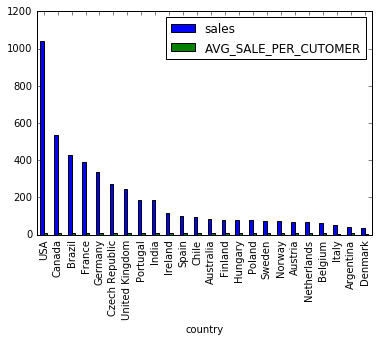

In [33]:
df.plot.bar()

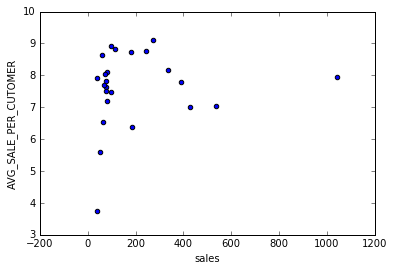

In [34]:
df.plot(x = "sales", y="AVG_SALE_PER_CUTOMER", kind = "scatter")